In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime 

In [96]:
stocks = ['AAPL', 'FB', 'NFLX', 'AMZN', 'GOOG']
indices = ['DJI', 'GSPC']

market_dfs = {}
for symbol in stocks + indices:
    market_dfs[symbol] = pd.read_csv(symbol + '.csv')

In [111]:
def plot_prices(symbols, dfs, standardize=False):
    # Figsize
    plt.figure(figsize=(10,6))
    
    # Plot each stock's price
    for symbol in symbols: 
        prices = dfs[symbol].Close / np.mean(dfs[symbol].Close) if standardize else dfs[symbol].Close
        plt.plot(prices)
        date = dfs[symbol].Date
        
    # Plot config
    locs, _ = plt.xticks()
    plt.xticks(locs[1:-1], date[0:-1:len(date)//(len(locs)-3)])
    plt.gca().legend(symbols)
    plt.title("Standardized Price over Time" if standardize else "Price over Time")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.show()

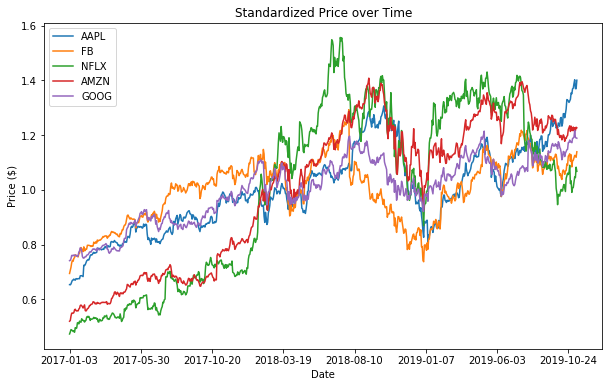

In [112]:
plot_prices(stocks, market_dfs, standardize=True)

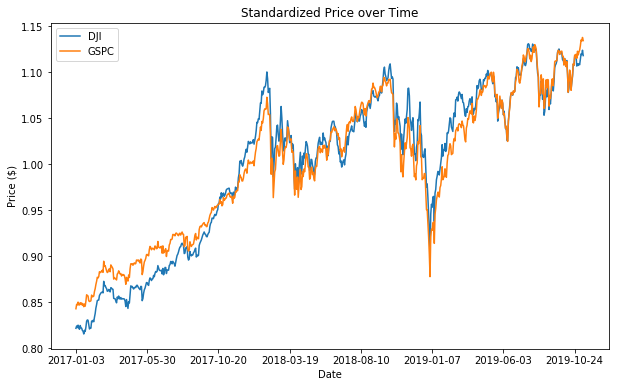

In [119]:
plot_prices(indices, market_dfs, standardize=True)

In [146]:
df_2019 = pd.read_csv('nytimes_2019.csv')
df_2017_18 = pd.read_csv('nytimes_2017_2018.csv')

news_df = pd.concat([df_2017_18, df_2019], ignore_index=True)
news_df.columns

Index(['Unnamed: 0', 'web_url', 'snippet', 'lead_paragraph', 'abstract',
       'print_page', 'source', 'headline', 'headline_kicker',
       'headline_content_kicker', 'headline_print_headline', 'headline_name',
       'headline_seo', 'headline_sub', 'keywords', 'pub_date', 'document_type',
       'news_desk', 'section_name', 'byline', 'type_of_material',
       'word_count'],
      dtype='object')

In [147]:
# percentage of each column that's missing
missing_percents = news_df.isna().sum() / len(news_df)
print(missing_percents)

cols_to_drop = ['Unnamed: 0', 'web_url', 'byline', 'news_desk']
for col in news_df.columns:
    if missing_percents[col] > 0.2:
        cols_to_drop.append(col)

Unnamed: 0                 0.000000
web_url                    0.000063
snippet                    0.000567
lead_paragraph             0.000851
abstract                   0.000473
print_page                 0.341855
source                     0.000000
headline                   0.000000
headline_kicker            0.866316
headline_content_kicker    1.000000
headline_print_headline    0.240260
headline_name              1.000000
headline_seo               1.000000
headline_sub               1.000000
keywords                   0.000000
pub_date                   0.000000
document_type              0.000000
news_desk                  0.053965
section_name               0.000000
byline                     0.000000
type_of_material           0.016234
word_count                 0.000000
dtype: float64


In [148]:
print(cols_to_drop)
news_df = news_df.drop(cols_to_drop,axis=1)

['Unnamed: 0', 'web_url', 'byline', 'news_desk', 'print_page', 'headline_kicker', 'headline_content_kicker', 'headline_print_headline', 'headline_name', 'headline_seo', 'headline_sub']


In [149]:
def add_sentiment(df, col):
    def polarity_and_subjectivity(x):
        sentiment = TextBlob(str(x)).sentiment
        return sentiment.polarity, sentiment.subjectivity
    df['polarity'], df['subjectivity'] = zip(*df[col].map(polarity_and_subjectivity))

add_sentiment(news_df, 'abstract')

In [162]:
news_df['date'] = news_df['pub_date'].apply(lambda x: x.strip()[:10])
news_df.tail()

,snippet,lead_paragraph,abstract,source,headline,keywords,pub_date,document_type,section_name,type_of_material,word_count,polarity,subjectivity,date
31719,Shares of Beyond Meat Inc plunged more than 20...,(Reuters) - Shares of Beyond Meat Inc plunged ...,Shares of Beyond Meat Inc plunged more than 20...,Reuters,Beyond Meat Butchered as Stock Sale Ban Lifted,[],2019-10-29T18:14:48+0000,article,Business Day,News,615,0.550000,0.700000,2019-10-29
31720,Private equity firm KKR & Co reported a 23% ye...,NEW YORK — Private equity firm KKR & Co report...,Private equity firm KKR & Co reported a 23% ye...,Reuters,KKR Earnings Slide 23% as Weaker Deal Activity...,[],2019-10-30T00:27:12+0000,article,Business Day,News,495,-0.100000,0.387500,2019-10-30
31721,Bank of America Corp will reward employees fo...,(Reuters) - Bank of America Corp will reward e...,Bank of America Corp will reward employees fo...,Reuters,Bank of America to Give Employees Special Bonu...,[],2019-10-30T00:24:34+0000,article,Business Day,News,235,0.198095,0.340952,2019-10-30
31722,Boeing Co Chief Executive Dennis Muilenburg fa...,WASHINGTON — Boeing Co Chief Executive Dennis ...,Boeing Co Chief Executive Dennis Muilenburg fa...,Reuters,Boeing CEO Accused of Telling 'Half-Truths' in...,[],2019-10-30T07:39:23+0000,article,Business Day,News,1124,0.000000,0.466667,2019-10-30
31723,Amazon.com Inc has invested around 45 billion ...,BENGALURU — Amazon.com Inc has invested around...,Amazon.com Inc has invested around 45 billion ...,Reuters,Amazon Pumps in More Than $600 Million Into In...,[],2019-10-30T07:29:33+0000,article,Business Day,News,172,0.000000,1.000000,2019-10-30


In [173]:
news_by_date = {"date": news_df.date.unique(),"subjectivity": [], "polarity": []}
for date in news_df.date.unique():
    news_by_date["subjectivity"].append(np.mean(news_df.loc[news_df['date'] == date]['subjectivity']))
    news_by_date["polarity"].append(np.mean(news_df.loc[news_df['date'] == date]['polarity']))
avg_sentiment_df = pd.DataFrame(news_by_date).sort_values(by="date")

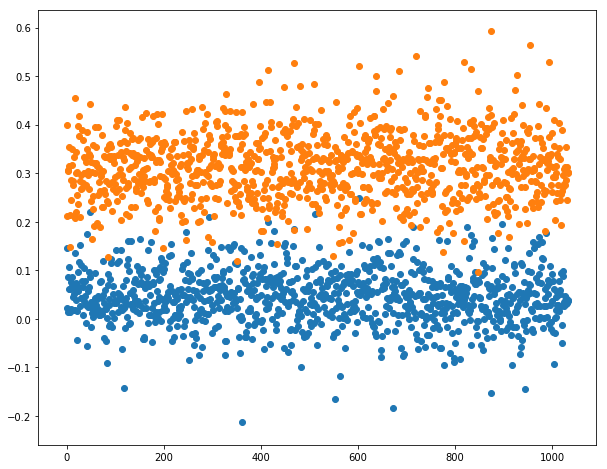

In [182]:
fig = plt.figure(figsize=(10,8))

plt.scatter(list(range(len(avg_sentiment_df))), avg_sentiment_df['polarity'])
plt.scatter(list(range(len(avg_sentiment_df))), avg_sentiment_df['subjectivity'])

plt.show()